In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
from plots import *

%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [5]:
rotation_rate = 21 # degrees per second. For Industrial
avg_frames = 12 # Number of frames to average over
frames_per_sec = 5 # 1/seconds # Correct? For MIcro. Choose, or do both



In [25]:
def V3_revolution(nproj, rr, avgf, fps, add_on=5 ):
    """
    Calculates scan time of one revolution with GoldenRatioV3
    nproj: number of projections
    rr: rotation rate in degrees per second
    avgf: number of frames to average over
    fps: frames per second
    add_on: number of seconds to add on to the scan time
    """

    exposure = nproj * avgf/fps
    rot = 360/rr
    scan_time = exposure + rot + add_on

    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio

def V3_angles(nproj, nrevs, starting=0):
    angles = np.zeros((nrevs, nproj))

    golden_angle_sampling = lambda n, inc: np.mod((n * 1/((np.sqrt(5) - 1) / 2) * inc), inc)

    startings = golden_angle_sampling(np.arange(starting,nrevs), 360/nproj)

    linear_sampling = lambda s: np.linspace(s, s + 360, nproj, endpoint=False)

    return linear_sampling(startings).T

def V3_total_time( rr, avgf, fps, add_on=5,nproj=None, nrevs=None,total = None):

    if total is None:
        total = nproj * nrevs
    elif nproj is None:
        nproj = total//nrevs
    elif nrevs is None:
        nrevs = total//nproj       
    else:
        raise ValueError
    
    scan_time_rev, exposure_ratio = V3_revolution(nproj, rr, avgf, fps, add_on)

    return scan_time_rev * nrevs, exposure_ratio

def standard_CT_time_exposure(nproj, rr, avgf, fps, add_on=0):
    return V3_revolution(nproj, rr, avgf, fps, add_on)

def theoretical_golden_angle(nproj, rr, avgf, fps, add_on=0 ):

    rotation = 137.5/rr
    exposure = avgf/fps
    scan_time = (rotation + exposure + add_on)*nproj
    exposure_ratio = nproj*exposure/scan_time
    return scan_time, exposure_ratio

def experimental_golden_angle(nproj, rr, avgf, fps, add_on=5):
    metallic_means = lambda n: (180* (n + np.sqrt(n**2 +4)))%360
    golden= metallic_means(1)
    golden = np.min([golden, np.abs(360-golden)])
    angles = np.arange(0, nproj* golden, golden)%360
    rotations = np.array([np.abs(angles[i] - angles[i-1]) for i in range(1, len(angles))])

    rotation = np.sum(rotations/rr)
    exposure = nproj*avgf/fps
    scan_time = rotation + exposure + add_on*nproj
    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio
    

    


In [52]:
nrevs = np.arange(1, 51)
nproj = 25

V3_tots, V3_exps = V3_total_time(rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=nrevs)
std_tots, std_exps = standard_CT_time_exposure(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
theo_tots, theo_exps = theoretical_golden_angle(nproj*nrevs, rotation_rate, avg_frames, frames_per_sec)
experiment_tots, experiment_exps = np.array([experimental_golden_angle(nproj*nr, rotation_rate, avg_frames, frames_per_sec) for nr in nrevs]).T

totals = 1000
nprojs = totals//nrevs #np.arange(10, 100)
print(nprojs)

V3_tots2 = np.zeros((len(nprojs), len(nrevs)))
V3_exps2 = np.zeros((len(nprojs), len(nrevs)))

for i, nproj in enumerate(nprojs):
    V3_tots2[i], V3_exps2[i] = V3_total_time(rotation_rate, avg_frames, frames_per_sec, nproj=nproj, nrevs=nrevs)


print(V3_tots2.shape)

[1000  500  333  250  200  166  142  125  111  100   90   83   76   71
   66   62   58   55   52   50   47   45   43   41   40   38   37   35
   34   33   32   31   30   29   28   27   27   26   25   25   24   23
   23   22   22   21   21   20   20   20]
(50, 50)


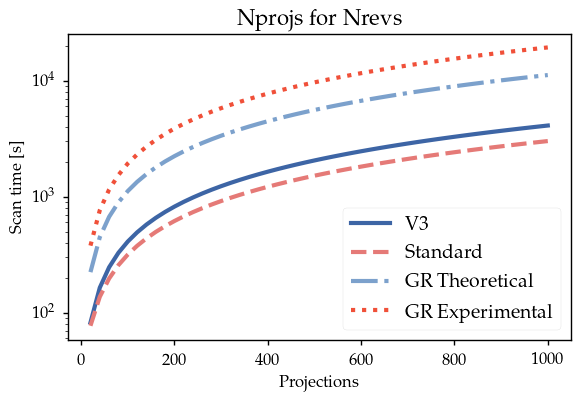

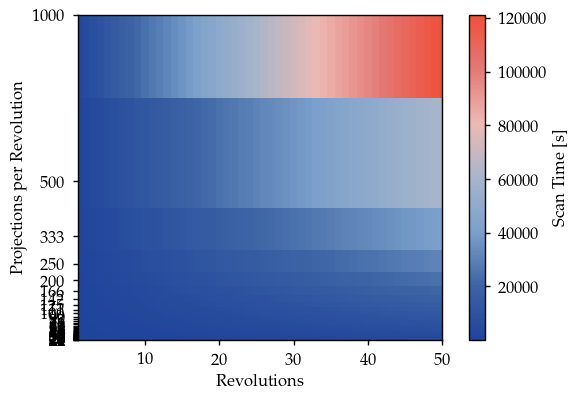

In [59]:
def plot_tot_time_comparison(nproj, nrevs, V3_tots, std_tots, theo_tots, experiment_tots, title="Nprojs for Nrevs"):
    choose_formatter(False)
    fig,ax = plt.subplots()

    ax.plot(nrevs*nproj, V3_tots, label="V3")
    ax.plot(nrevs*nproj, std_tots, label="Standard")
    ax.plot(nrevs*nproj, theo_tots, label="GR Theoretical")
    ax.plot(nrevs*nproj, experiment_tots, label="GR Experimental")

    ax.legend()
    ax.set_yscale("log")
    ax.set_ylabel("Scan time [s]")
    ax.set_xlabel("Projections")
    plt.title(title)

    plt.show()

def plot_V3_grid(nproj, nrevs, V3_tots, V3_exps, title="V3 Scan Times"):

    X,Y = np.meshgrid(nrevs, nproj)
    fig,ax = plt.subplots(1,1)

    ax.imshow(V3_tots, cmap = XRDCT_palette_cmp)
    # axs[1].pcolormesh(X,Y, V3_exps, cmap=XRDCT_palette_cmp)

    ax.set_xlabel("Revolutions")
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_ylabel("Projections per Revolution")
    ax.set_yticks(nproj)
    # ax.set_xticks(nrevs)

    plt.colorbar(ax.pcolormesh(X,Y, V3_tots, cmap = XRDCT_palette_cmp), ax=ax, label="Scan Time [s]")
    plt.show()


plot_tot_time_comparison(nproj, nrevs, V3_tots, std_tots, theo_tots, experiment_tots, title="Nprojs for Nrevs")

plot_V3_grid(nprojs, nrevs, V3_tots2, V3_exps2, title="V3 Scan Times")

In [46]:
# print(V3_angles(10, 10))

%timeit V3_angles(10, 10)
print(V3_angles(10, 10))

29.6 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
[[  0.          36.          72.         108.         144.
  180.         216.         252.         288.         324.        ]
 [ 22.24922359  58.24922359  94.24922359 130.24922359 166.24922359
  202.24922359 238.24922359 274.24922359 310.24922359 346.24922359]
 [  8.49844719  44.49844719  80.49844719 116.49844719 152.49844719
  188.49844719 224.49844719 260.49844719 296.49844719 332.49844719]
 [ 30.74767078  66.74767078 102.74767078 138.74767078 174.74767078
  210.74767078 246.74767078 282.74767078 318.74767078 354.74767078]
 [ 16.99689438  52.99689438  88.99689438 124.99689438 160.99689438
  196.99689438 232.99689438 268.99689438 304.99689438 340.99689438]
 [  3.24611797  39.24611797  75.24611797 111.24611797 147.24611797
  183.24611797 219.24611797 255.24611797 291.24611797 327.24611797]
 [ 25.49534157  61.49534157  97.49534157 133.49534157 169.49534157
  205.49534157 241.49534157 277.49534157 313.49534157 34

In [70]:
choose_formatter(incscape=False)


def plot_temp_resolution(nprojs, scan_times, exp_ratios, title= "Golden Ratio V3 Sampling", markers= []):
    """
    Plots the temporal resolution of the scan
    nprojs: number of projections
    scan_time: scan time in seconds
    """
    fig, ax = plt.subplots()

    ax1 = ax.twinx()
    left, = ax.plot(nprojs, scan_times, "-.", color = "#1F449C", label= "Temporal Resolution")
    right, = ax1.plot(nprojs, exp_ratios, ":", color = "#F05039", label= "Exposure Ratio")


    ax.set_xlabel('Projections per Revolution')
    # ax.set_xticks(nprojs)
    # ax.set_xticklabels([str(int(n)) for n in nprojs])
    ax.set_ylabel('Temporal Resolution (s)', color = left.get_color())
    ax1.set_ylabel('Exposure Ratio', color = right.get_color())

    ax.tick_params(axis='y', colors=left.get_color())
    ax1.tick_params(axis='y', colors=right.get_color())

    # plt.legend(handles=[left, right])

    if markers != []:
        mark_plot(markers, ax, ax1, scan_times, exp_ratios, nprojs)
        

    plt.title(title)
    plt.savefig(f"../Results/Golden Angle/temporal_resolution_{title}.pdf", format="pdf") # Save figure, locate Results folder
    plt.show()

def mark_plot(markers, ax, ax1, scan_times, exp_ratios, nprojs):

    for m in markers:
            try:
                arg = np.argwhere(np.isclose(nprojs, [m], rtol=1e-2))[0][0]
                r = scan_times[arg]
                e = exp_ratios[arg]
                # ax.axvline(m, color = "black", linestyle = "--")
                ax.scatter(m, r, color = "black", marker = "o")
                ax.text(m+2, r-15, f"{m}: {int(r)}s {int(e*100)}\%", rotation=0, verticalalignment='bottom')
            except:
                print(f"Marker {m} not found in nprojs. Excluded from plot")
                pass
            finally:
                 continue
    return



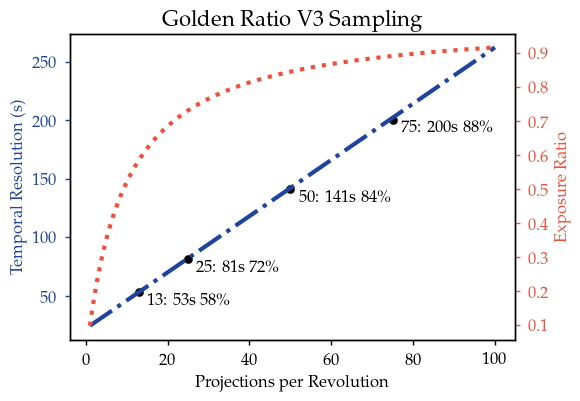

In [71]:
nprojs = np.linspace(1, 100, 1000)
times, ratios = V3_revolution(nprojs, rotation_rate, avg_frames, frames_per_sec)
markers = [13, 25, 50, 75]
plot_temp_resolution(nprojs, times, ratios, markers=markers)

In [130]:
# Plot histogram of distributions

def plot_angle_distributions(angles, title= "Sampling Distributions", bins=500):

    fig, ax = plt.subplots()
    angles = angles.flatten()
    uniform = np.linspace(0, 360, len(angles))

    ax.hist(angles, bins=bins, alpha=0.5, label="GRV3")
    ax.hist(uniform, bins=bins, alpha=0.5, label="Uniform")
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Number of occurences")
    ax.set_title("Sampling Distributions")

    ax.legend(loc="upper right")
    plt.show()

    mu_gr, mu = np.mean(angles), np.mean(np.linspace(0, 360, len(angles)))

    return


# def plot_time_angle(angles, scan_time, uniform_time, title= "Sampling Distributions" ) # RSD: Necessary???




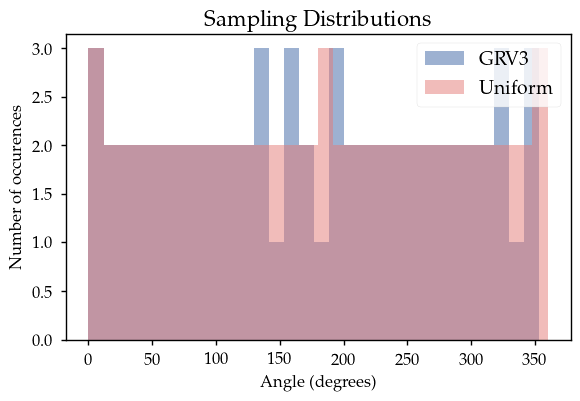

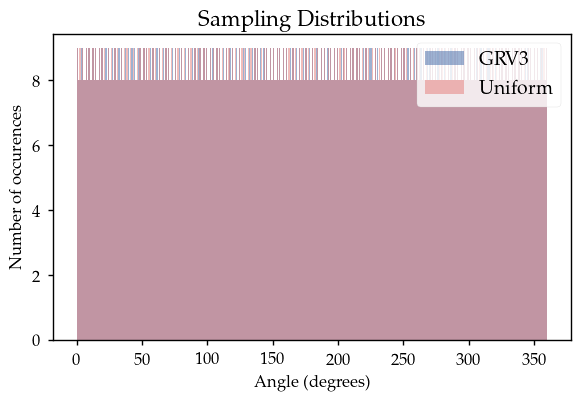

In [131]:
angles = V3_angles(21, 3)

plot_angle_distributions(angles, bins=30)


angles = V3_angles(13, 233)

plot_angle_distributions(angles, bins=360)